# Telecom churn prediction Case study

## Problem Statement 

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Understanding customer behaviour during churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

In [3]:
# Importing the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

### Data understanding and cleaning

In [5]:
# reading the data
df = pd.read_csv('C:\\Users\\RDRL\\Downloads\\Upgrad\\CLASS IMBALANCE CASE STUDY\\telecom_churn_data.csv')
print(df.shape)
df.head()

(99999, 226)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [6]:
df.info(226)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

## Filtering high values customers

High-value churn
In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce the churn of the high-value customers, we will be able to reduce significant revenue leakage.

 

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

In [7]:
df.iloc[:,141:145].head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9
0,362,252,252,0
1,74,384,283,121
2,168,315,116,358
3,230,310,601,410
4,196,350,287,200


In [8]:
df.iloc[:,141:145].isnull().sum()

total_rech_amt_6    0
total_rech_amt_7    0
total_rech_amt_8    0
total_rech_amt_9    0
dtype: int64

In [9]:
df['avg_rech_amt_6_7'] = (df['total_rech_amt_6'] + df['total_rech_amt_7']) / 2

df = df.loc[(df['avg_rech_amt_6_7'] > np.percentile(df['avg_rech_amt_6_7'], 70))]

df.drop(['avg_rech_amt_6_7'], axis=1, inplace=True)

In [10]:
print(df.shape)
df.head()

(29979, 226)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,0,NaN,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,0,NaN,1.0,1.0,NaN,315,21.03,910.65,122.16,0.0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,492.846,...,0,NaN,NaN,1.0,NaN,2607,0.00,0.00,0.00,0.0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,430.975,...,0,NaN,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0
17,7000187447,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,690.008,...,0,NaN,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0


Here we filter out the high values customers as they give 80% from the total buissness 

The following data preparation steps are crucial for this problem:

 

1. Filter high-value customers

As mentioned above, you need to predict churn only for high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

 

After filtering the high-value customers, you should get about 30k rows.

 

2. Tag churners and remove attributes of the churn phase

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9

total_og_mou_9

vol_2g_mb_9

vol_3g_mb_9


After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

#### Creating the target variable

In [11]:
# Here we are deriving the target varible from the columns 'total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9'
cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
df['Sum'] = df['total_ic_mou_9'] + df['total_og_mou_9'] + df['vol_2g_mb_9'] + df['vol_3g_mb_9']
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Sum
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,NaN,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,0.00
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,NaN,1.0,1.0,NaN,315,21.03,910.65,122.16,0.0,177.09
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,492.846,...,NaN,NaN,1.0,NaN,2607,0.00,0.00,0.00,0.0,1077.95
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,430.975,...,NaN,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0,590.30
17,7000187447,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,690.008,...,NaN,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0,718.21


In [12]:
df["Churn"] = np.where(df.Sum == 0, 1 , 0) 

In [13]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Sum,Churn
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,0.00,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,1.0,1.0,NaN,315,21.03,910.65,122.16,0.0,177.09,0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,492.846,...,NaN,1.0,NaN,2607,0.00,0.00,0.00,0.0,1077.95,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,430.975,...,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0,590.30,0
17,7000187447,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,690.008,...,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0,718.21,0


In [14]:
df1 = df.drop("Sum", axis = 1)

In [15]:
df1.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,NaN,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,NaN,1.0,1.0,NaN,315,21.03,910.65,122.16,0.0,0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,492.846,...,NaN,NaN,1.0,NaN,2607,0.00,0.00,0.00,0.0,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,430.975,...,NaN,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0,0
17,7000187447,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,690.008,...,NaN,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0,0


In [16]:
df1.Churn.value_counts()

0    27390
1     2589
Name: Churn, dtype: int64

#### Dropping Churn Phase features

In [17]:
# Dropping the columns having _9 
x = []
for i in df1.columns:
    if i[-1] == "9":
        x.append(i)        

In [18]:
df1 = df1.drop(x, axis = 1)

In [19]:
df1.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,...,0,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,...,0,NaN,1.0,1.0,315,21.03,910.65,122.16,0.0,0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,...,0,NaN,NaN,1.0,2607,0.00,0.00,0.00,0.0,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,...,0,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0,0
17,7000187447,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,690.008,18.980,...,0,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0,0


In [20]:
df1.Churn.value_counts(normalize = True)

0    0.91364
1    0.08636
Name: Churn, dtype: float64

In [21]:
# Identifying all the columns with unique values.
cols_unique = []
for i in df1.columns:
    if df1[i].nunique() == 1:
        cols_unique.append(i)

In [22]:
# List of all the columns containing unique values
cols_unique

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [23]:
df1 = df1.drop(cols_unique, axis = 1)

Here we have dropped all the columns containing unique values.

In [24]:
df1.shape

(29979, 160)

##### Now we will drop the columns having null values more then 30%

In [25]:
per = (df1.isnull().sum()/len(df1))*100

null_df = pd.DataFrame(per, columns = ['percentage'])

In [26]:
col_drop_30  = list(null_df.loc[(null_df.percentage > 30),:].index)

In [27]:
col_drop_30

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [28]:
# Dropping all the values
df1 = df1.drop(col_drop_30, axis = 1)

In [29]:
df1.shape

(29979, 130)

In [30]:
# lets check the dataset again
(df1.isnull().sum() * 100 / len(df1)).sort_values(ascending = False)

std_og_mou_8          3.128857
loc_og_t2c_mou_8      3.128857
std_ic_t2f_mou_8      3.128857
std_ic_t2m_mou_8      3.128857
loc_og_t2f_mou_8      3.128857
                        ...   
max_rech_amt_8        0.000000
last_day_rch_amt_6    0.000000
last_day_rch_amt_7    0.000000
last_day_rch_amt_8    0.000000
mobile_number         0.000000
Length: 130, dtype: float64

##### Now we need to impute the null values.

In [31]:
# Listing all the columns containing missing values.
df_null = ((df1.isnull().sum()/len(df1))*100).reset_index(name='missing_cnt')
df_null = df_null.loc[df_null['missing_cnt'] > 0].sort_values(by = 'missing_cnt', ascending = False)

In [32]:
df_null.values

array([['loc_og_t2f_mou_8', 3.128856866473198],
       ['loc_og_t2m_mou_8', 3.128856866473198],
       ['std_og_mou_8', 3.128856866473198],
       ['og_others_8', 3.128856866473198],
       ['std_og_t2f_mou_8', 3.128856866473198],
       ['loc_ic_t2t_mou_8', 3.128856866473198],
       ['std_og_t2m_mou_8', 3.128856866473198],
       ['loc_ic_t2m_mou_8', 3.128856866473198],
       ['std_og_t2t_mou_8', 3.128856866473198],
       ['loc_ic_t2f_mou_8', 3.128856866473198],
       ['loc_og_mou_8', 3.128856866473198],
       ['loc_ic_mou_8', 3.128856866473198],
       ['loc_og_t2c_mou_8', 3.128856866473198],
       ['std_ic_t2t_mou_8', 3.128856866473198],
       ['isd_og_mou_8', 3.128856866473198],
       ['std_ic_t2m_mou_8', 3.128856866473198],
       ['spl_og_mou_8', 3.128856866473198],
       ['isd_ic_mou_8', 3.128856866473198],
       ['onnet_mou_8', 3.128856866473198],
       ['loc_og_t2t_mou_8', 3.128856866473198],
       ['ic_others_8', 3.128856866473198],
       ['std_ic_mou_8', 3.12885

In [33]:
df1.columns.values

array(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
       'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8',
       'og_others_6', 'og_others_7', 'og_others_

We will drop columns which will not have any effect on our model like mobile number, date_of_last_rech_6, date_of_last_rech_7, date_of_last_rech_8

###### 2 columns are of date i.e. date_of_last_rech_7, date_of_last_rech_6. Others are all recharge columns i.e. numeric and minimum could be 0. So we can impute minimum value of 0 to each columns.

In [34]:
df1 = df1.drop(['mobile_number', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis =1)

In [35]:
df1.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0,0,0,0,315,21.03,910.65,122.16,0.0,0
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,...,0,0,0,0,2607,0.00,0.00,0.00,0.0,0
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,...,0,0,0,0,511,0.00,2.45,21.89,0.0,0
17,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,...,0,0,0,0,667,0.00,0.00,0.00,0.0,0


##### Imputing all null values of recharge columns with 0

In [36]:
df1 = df1.fillna(0)

In [37]:
df1.isnull().sum()

arpu_6         0
arpu_7         0
arpu_8         0
onnet_mou_6    0
onnet_mou_7    0
              ..
aug_vbc_3g     0
jul_vbc_3g     0
jun_vbc_3g     0
sep_vbc_3g     0
Churn          0
Length: 126, dtype: int64

# EDA 

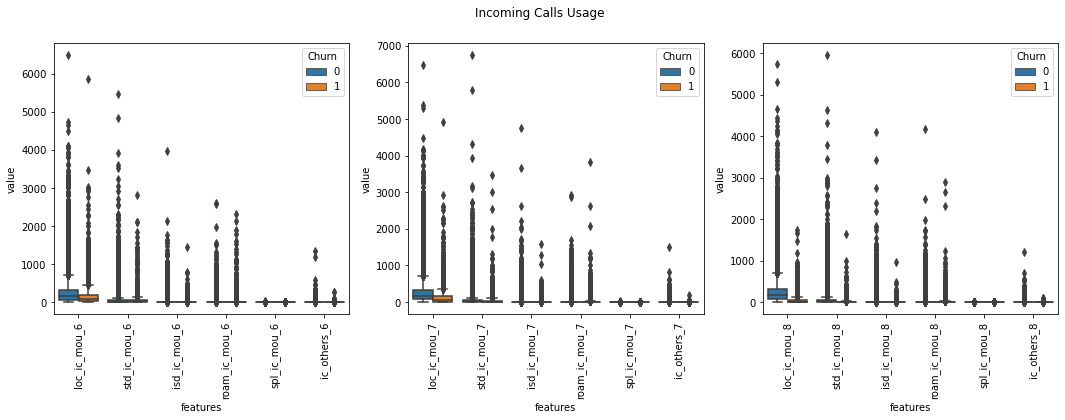

In [38]:
# Ploting the boxplot for the Incoming call usage
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8']]

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([df1[cols[i]], df1['Churn']], axis=1)
    X = pd.melt(X,id_vars="Churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="Churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

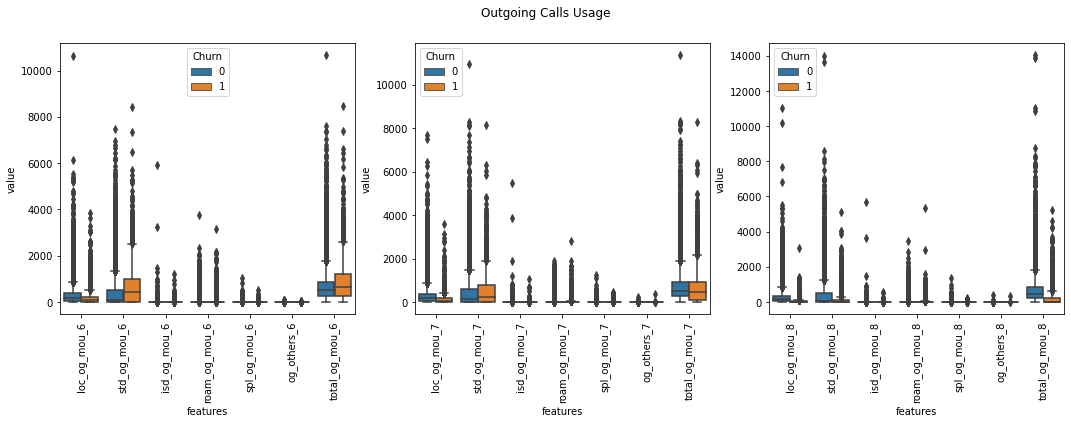

In [39]:
# Plotting the boxplot tu vizualise the outgoing calls
cols = [['loc_og_mou_6','std_og_mou_6','isd_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','isd_og_mou_7','roam_og_mou_7','spl_og_mou_7','og_others_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','isd_og_mou_8','roam_og_mou_8','spl_og_mou_8','og_others_8','total_og_mou_8']]


# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([df1[cols[i]], df1['Churn']], axis=1)
    X = pd.melt(X,id_vars="Churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="Churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

As we can notice here there are outliers in almost every columns.

#### As we can see here there is outliers in every columns

Now we will idenify as well as treat the outliers in the given data

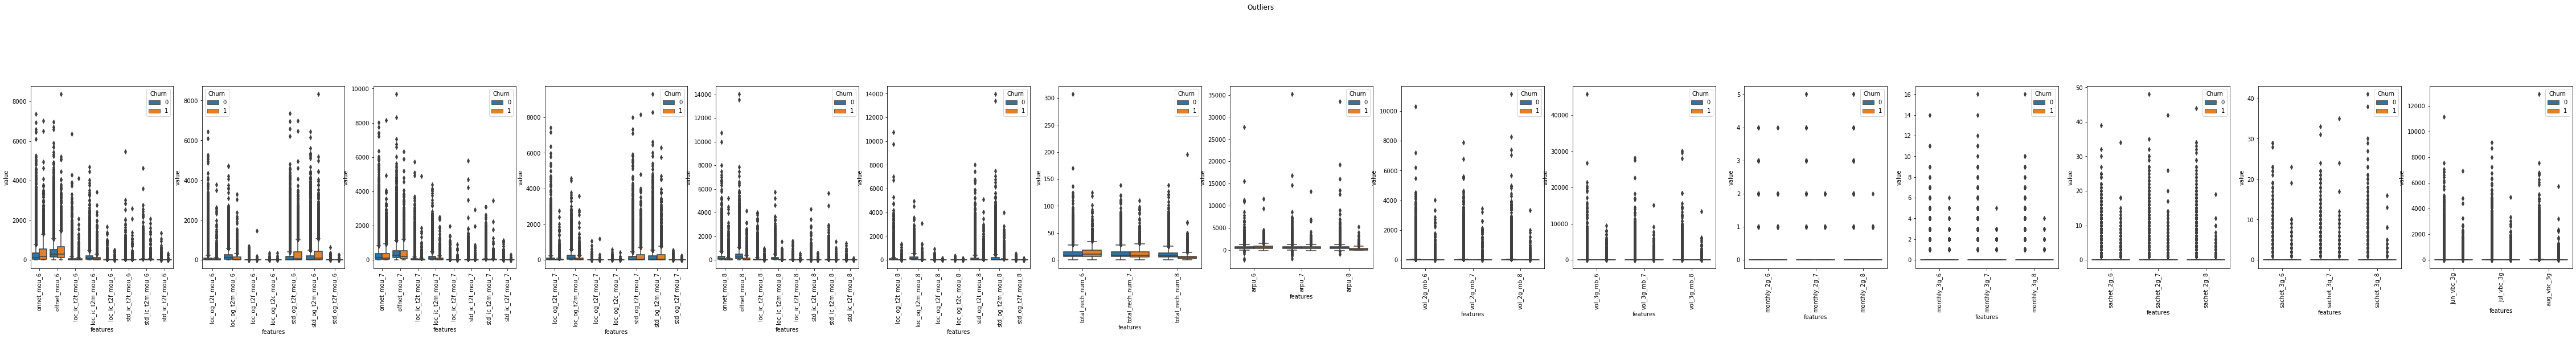

In [40]:
cols=[['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8'],
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'], 
        ['arpu_6','arpu_7','arpu_8'],
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['monthly_2g_6','monthly_2g_7','monthly_2g_8'],
        ['monthly_3g_6','monthly_3g_7','monthly_3g_8'],
        ['sachet_2g_6','sachet_2g_7','sachet_2g_8'],
        ['sachet_3g_6','sachet_3g_7','sachet_3g_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']]

# plotting the box plot for cols
plt.figure(figsize=(80, 20))
#ic call usage
for i in range(0,15):
    plt.subplot(3, 15, i+1)
    X = pd.concat([df1[cols[i]], df1['Churn']], axis=1)
    X = pd.melt(X,id_vars="Churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="Churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outliers')

In [41]:
cols = list(df1.columns.values)
cols

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

In [42]:
cols_to_exclude = ['night_pck_user_6','night_pck_user_7','night_pck_user_8',
                   'fb_user_6','fb_user_7','fb_user_8',
                   'monthly_2g_6','monthly_2g_7','monthly_2g_8',
                   'monthly_3g_6','monthly_3g_7','monthly_3g_8',
                   'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                   'sachet_3g_6','sachet_3g_7','sachet_3g_8',
                   'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8',
                   'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_og_mou_6','og_others_6','spl_og_mou_7','og_others_7','spl_og_mou_8','og_others_8',
                   'loc_og_t2c_mou_6','std_og_t2f_mou_6','std_ic_t2f_mou_6','loc_ic_t2f_mou_6',
                   'loc_og_t2c_mou_7','std_og_t2f_mou_7','std_ic_t2f_mou_7','loc_ic_t2f_mou_7',
                   'loc_og_t2c_mou_8','std_og_t2f_mou_8','std_ic_t2f_mou_8','loc_ic_t2f_mou_8',
                   'aon','churn'
                  ]
cols = list(set(df1.columns).difference(set(cols_to_exclude)))

# iterate through the columns and cap the values with the 99th percentile
for col in cols:
    percentiles = df1[col].quantile([0.01,0.95]).values
    #data[col][data[col] <= percentiles[0]] = percentiles[0]
    df1[col][df1[col] >= percentiles[1]] = percentiles[1]

We'll need to remove the outliers at the 99th percentile for the below columns.

In [43]:
# remove the outliers with specific columns
data = df1.loc[~(
                    ((df1['roam_og_mou_8'] > 2200) & (df1['Churn'] == 1)) |
                    ((df1['arpu_7'] > 10000) & (df1['Churn'] == 1)) |
                    ((df1['loc_og_mou_8'] > 2000) & (df1['Churn'] == 1)) |
                    ((df1['loc_ic_mou_7'] > 4000) & (df1['Churn'] == 1)) |
                    ((df1['std_og_mou_7'] > 7000) & (df1['Churn'] == 1)) |
                    ((df1['vol_2g_mb_8'] > 2500) & (df1['Churn'] == 1)) 
                 )
               ]

In [44]:
cols=[['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8'], 
        ['arpu_6','arpu_7','arpu_8'],
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['monthly_2g_6','monthly_2g_7','monthly_2g_8'],
        ['monthly_3g_6','monthly_3g_7','monthly_3g_8'],
        ['sachet_2g_6','sachet_2g_7','sachet_2g_8'],
        ['sachet_3g_6','sachet_3g_7','sachet_3g_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']]


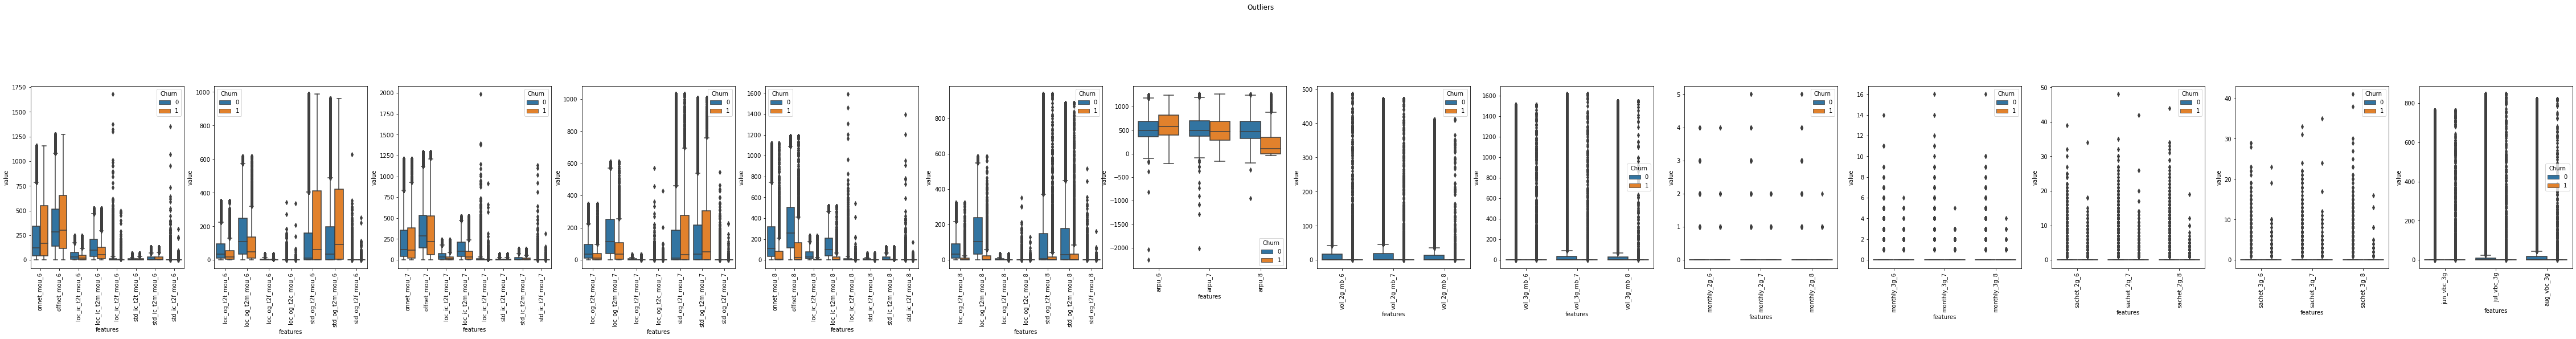

In [45]:
# plotting the box plot for cols
plt.figure(figsize=(80, 20))
#ic call usage
for i in range(0,14):
    plt.subplot(3, 14, i+1)
    X = pd.concat([df1[cols[i]], df1['Churn']], axis=1)
    X = pd.melt(X,id_vars="Churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="Churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outliers')

Hence the outliers has been treated.

# Handling Multicollinearity using Correlation

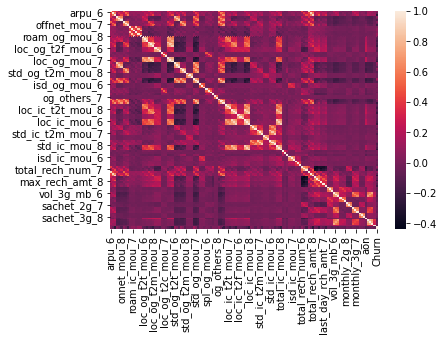

In [46]:
sns.heatmap(df1.corr())

In [47]:
cor = df1.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
z = cor[(cor > 0.60) | (cor < -0.60)].sort_values(ascending = False)

In [48]:
ourdf = pd.DataFrame(z).reset_index()

In [49]:
ourdf = ourdf.rename(columns = {'level_0': 'param_1', 'level_1': 'param_2', 0: 'Corr_Val'})

In [50]:
ourdf.head(20)

,param_1,param_2,Corr_Val
0,total_rech_amt_8,arpu_8,0.935997
1,total_rech_amt_6,arpu_6,0.916521
2,loc_ic_mou_8,loc_ic_t2m_mou_8,0.912858
3,total_ic_mou_8,loc_ic_mou_8,0.911720
4,total_ic_mou_6,loc_ic_mou_6,0.910176
5,total_rech_amt_7,arpu_7,0.905711
6,loc_ic_mou_6,loc_ic_t2m_mou_6,0.904781
7,total_ic_mou_7,loc_ic_mou_7,0.904097
8,loc_ic_mou_7,loc_ic_t2m_mou_7,0.900854
9,loc_og_mou_8,loc_og_t2m_mou_8,0.889312


In [51]:
drop_col_list = ['total_rech_amt_8',
 'std_ic_t2m_mou_8',
 'vol_3g_mb_7',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2f_mou_7',
 'vol_3g_mb_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'total_og_mou_7',
 'loc_og_t2f_mou_7',
 'loc_ic_t2t_mou_8',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_6',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_t2t_mou_7',
 'loc_ic_t2f_mou_6',
 'loc_og_t2m_mou_8',
 'std_ic_t2m_mou_7',
 'total_og_mou_8',
 'std_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'total_og_mou_6',
 'total_rech_amt_7',
 'std_og_t2t_mou_8',
 'loc_og_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'total_ic_mou_6',
 'vol_3g_mb_6',
 'total_rech_amt_6',
 'total_ic_mou_7',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'total_ic_mou_8',
 'std_ic_t2m_mou_6',
 'loc_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7']

In [52]:
df2 = df1.drop(drop_col_list, axis = 1)

In [53]:
df2.shape

(29979, 87)

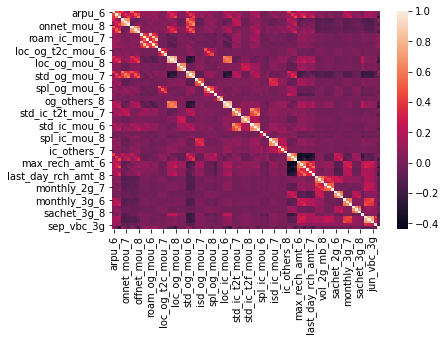

In [54]:
sns.heatmap(df2.corr())

In [55]:
# All the multicollinearity has been treated succefully and now we will proceed towards the rest of analysis 

Now we will be performing EDA to gain insight of the data and extract useful information. 

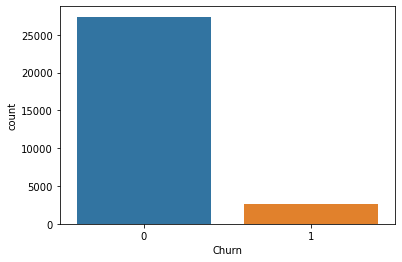

In [56]:
sns.countplot(x='Churn',data=df2)

 As we can see there is a clear case of class imbalance
##### So we need to handle the class imbalance

# Data Preprocessing

In [57]:
df2.shape

(29979, 87)

In [58]:
df2.describe(include = 'all')

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,...,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,559.984864,561.808469,506.679411,263.305352,270.620813,232.417121,384.975464,389.500778,340.743349,9.012917,...,0.173321,0.138063,0.150339,0.140498,1264.158911,96.543861,99.592162,86.292490,1.165508,0.08636
std,283.138216,285.506946,318.335252,321.398966,335.027036,306.619433,337.622252,343.844521,324.438513,23.901853,...,0.583178,0.875984,0.969779,0.975212,975.181038,223.071527,230.855810,205.994134,4.314638,0.28090
min,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,364.352500,365.235000,289.782000,41.170000,41.045000,27.070000,137.340000,135.690000,95.730000,0.000000,...,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,495.951000,493.781000,452.232000,125.890000,125.560000,99.590000,282.260000,282.040000,241.040000,0.000000,...,0.000000,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,704.184500,700.986000,671.349500,353.500000,360.360000,298.215000,523.625000,532.905000,483.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1923.500000,1.600000,2.025000,0.000000,0.000000,0.00000
max,1240.976700,1261.848400,1258.703300,1154.900000,1208.691000,1115.857000,1271.757000,1287.221000,1188.523000,94.663000,...,16.000000,29.000000,35.000000,41.000000,4321.000000,819.257000,845.429000,762.122000,18.631000,1.00000


In [59]:
# prepare the dataset
y = df2['Churn']
X = df2.drop('Churn', axis=1)

In [60]:
X_col=list(X)

# Train Test Split

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
df_train, df_test = train_test_split(df2, test_size=0.2, random_state=42, stratify=df2.Churn)

In [63]:
df_train.shape, df_test.shape

((23983, 87), (5996, 87))

In [64]:
df_train.Churn.value_counts(normalize=True)

0    0.913647
1    0.086353
Name: Churn, dtype: float64

In [65]:
df_test.Churn.value_counts(normalize=True)

0    0.913609
1    0.086391
Name: Churn, dtype: float64

# Featuring Scaling

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
scaler = StandardScaler()

In [68]:
df_train[X_col]=scaler.fit_transform(df_train[X_col])
df_test[X_col]=scaler.transform(df_test[X_col])

In [69]:
X_train = df_train.drop('Churn', axis=1)
y_train = df_train['Churn']
X_test = df_test.drop('Churn', axis=1)
y_test = df_test['Churn']

In [70]:
X_train.describe(include = 'all')

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,...,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04,2.398300e+04
mean,-2.158623e-16,-1.022407e-16,1.180448e-17,9.874796e-17,-9.053632e-17,-6.429970e-18,1.945656e-16,8.499226e-18,4.163510e-17,3.458157e-16,...,5.111016e-16,4.344605e-16,-5.234269e-16,3.305440e-16,-4.428139e-16,9.367073e-17,-7.266052e-16,-1.833317e-15,-6.854446e-16,1.066232e-15
std,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,...,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00
min,-9.926341e+00,-6.480181e+00,-4.558187e+00,-8.199464e-01,-8.080293e-01,-7.573989e-01,-1.141082e+00,-1.133499e+00,-1.051428e+00,-3.779000e-01,...,-2.982105e-01,-2.972986e-01,-1.588999e-01,-1.599242e-01,-1.440524e-01,-1.113150e+00,-4.328324e-01,-4.324633e-01,-4.198044e-01,-2.691978e-01
25%,-6.902309e-01,-6.900307e-01,-6.804281e-01,-6.917349e-01,-6.846865e-01,-6.691997e-01,-7.342559e-01,-7.377591e-01,-7.546974e-01,-3.779000e-01,...,-2.982105e-01,-2.972986e-01,-1.588999e-01,-1.599242e-01,-1.440524e-01,-8.045587e-01,-4.328324e-01,-4.324633e-01,-4.198044e-01,-2.691978e-01
50%,-2.249809e-01,-2.376504e-01,-1.696151e-01,-4.272705e-01,-4.314241e-01,-4.326247e-01,-3.057249e-01,-3.121699e-01,-3.055130e-01,-3.779000e-01,...,-2.982105e-01,-2.972986e-01,-1.588999e-01,-1.599242e-01,-1.440524e-01,-3.550438e-01,-4.328324e-01,-4.324633e-01,-4.198044e-01,-2.691978e-01
75%,5.053372e-01,4.906930e-01,5.192972e-01,2.805290e-01,2.668111e-01,2.146539e-01,4.104181e-01,4.154704e-01,4.361518e-01,-3.779000e-01,...,-2.982105e-01,-2.972986e-01,-1.588999e-01,-1.599242e-01,-1.440524e-01,6.674227e-01,-4.260888e-01,-4.251326e-01,-4.198044e-01,-2.691978e-01
max,2.397942e+00,2.453022e+00,2.363183e+00,2.772713e+00,2.805237e+00,2.887026e+00,2.624723e+00,2.607724e+00,2.609075e+00,3.555574e+00,...,2.567948e+01,2.729201e+01,3.290992e+01,3.502780e+01,4.185037e+01,3.146441e+00,3.225938e+00,3.234737e+00,3.266035e+00,4.067082e+00


In [71]:
#!pip install imblearn  

In [72]:
#pip install delayed

# Handling Class Imbalance

In [73]:
# Class Imbalance through Adasyn
from collections import Counter

# ADASYN
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42, n_neighbors=5)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled_ada).items()))

[(0, 21912), (1, 21652)]


NOw we use X_resampled_ada for X_train, y_resampled_ada for y_train

In [74]:
X_train = X_resampled_ada
y_train = y_resampled_ada

# MODEL BUILDING

# Using Logistic Reason

#### Running our First Training Model

In [75]:
import statsmodels.api as sm

In [76]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                43564
Model:                            GLM   Df Residuals:                    43477
Model Family:                Binomial   Df Model:                           86
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17536.
Date:                Sun, 30 May 2021   Deviance:                       35071.
Time:                        14:13:01   Pearson chi2:                 3.28e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.6690      0.028    -60.079      0.000      -1.723      -1.615
arpu_6                 0.1698      0.031      5.465      0.000       0.109       0.231
arpu_7                 0.3010      0.033      9.198      0.000       0.237       0.365
arpu_8                 0.2384      0.039      6.044      0.000       0.161       0.316
onnet_mou_6            0.2185      0.046      4.706      0.000       0.127       0.309
onnet_mou_7            0.1646      0.058      2.825      0.005       0.050       0.279
onnet_mou_8           -0.3991      0.056     -7.151      0.000      -0.509      -0.290
offnet_mou_6           0.1274      0.049      2.618      0.009       0.032       0.223
offnet_mou_7           0.3212      0.058      5.538      0.000       0.207       0.435
offnet_mou_8          -0.4010      0.057     -7.040      0.000      -0.513      -0.289
roam_ic_mou_6         -0.0579      0.031     -1.849      0.065      -0.119       0.003
roam_ic_mou_7          0.1168      0.031      3.784      0.000       0.056       0.177
roam_ic_mou_8         -0.0242      0.027     -0.897      0.370      -0.077       0.029
roam_og_mou_6          0.0308      0.030      1.014      0.310      -0.029       0.090
roam_og_mou_7         -0.1477      0.030     -4.994      0.000      -0.206      -0.090
roam_og_mou_8          0.3599      0.027     13.539      0.000       0.308       0.412
loc_og_t2c_mou_6      -0.1108      0.021     -5.166      0.000      -0.153      -0.069
loc_og_t2c_mou_7       0.0268      0.022      1.199      0.230      -0.017       0.071
loc_og_t2c_mou_8       0.0663      0.022      3.017      0.003       0.023       0.109
loc_og_mou_6          -0.2677      0.049     -5.410      0.000      -0.365      -0.171
loc_og_mou_7          -0.1635      0.058     -2.795      0.005      -0.278      -0.049
loc_og_mou_8          -0.3782      0.059     -6.425      0.000      -0.494      -0.263
std_og_t2f_mou_6      -0.0607      0.022     -2.745      0.006      -0.104      -0.017
std_og_t2f_mou_7      -0.0542      0.034     -1.584      0.113      -0.121       0.013
std_og_t2f_mou_8      -0.0327      0.036     -0.898      0.369      -0.104       0.039
std_og_mou_6          -0.2125      0.059     -3.611      0.000      -0.328      -0.097
std_og_mou_7          -0.1328      0.073     -1.819      0.069      -0.276       0.010
std_og_mou_8          -0.0560      0.068     -0.823      0.411      -0.190       0.077
isd_og_mou_6          -0.0022      0.019     -0.121      0.904      -0.039       0.034
isd_og_mou_7           0.0414      0.019      2.219      0.026       0.005       0.078
isd_og_mou_8           0.0540      0.020      2.724      0.006       0.015       0.093
spl_og_mou_6          -0.0269      0.018     -1.474      0.140      -0.063       0.009
spl_og_mou_7          -0.0205      0.0

## Feature Selection Using RFE

In [77]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [78]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, n_features_to_select = 15)             # running RFE with 15 variables as output

In [79]:
%%time
rfe = rfe.fit(X_train, y_train)

Wall time: 41.6 s


In [80]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', False, 19),
 ('arpu_7', True, 1),
 ('arpu_8', False, 8),
 ('onnet_mou_6', False, 30),
 ('onnet_mou_7', False, 11),
 ('onnet_mou_8', False, 2),
 ('offnet_mou_6', False, 32),
 ('offnet_mou_7', False, 10),
 ('offnet_mou_8', False, 3),
 ('roam_ic_mou_6', False, 56),
 ('roam_ic_mou_7', False, 34),
 ('roam_ic_mou_8', False, 64),
 ('roam_og_mou_6', False, 59),
 ('roam_og_mou_7', False, 33),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2c_mou_6', False, 23),
 ('loc_og_t2c_mou_7', False, 62),
 ('loc_og_t2c_mou_8', False, 38),
 ('loc_og_mou_6', False, 18),
 ('loc_og_mou_7', False, 9),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2f_mou_6', False, 42),
 ('std_og_t2f_mou_7', False, 29),
 ('std_og_t2f_mou_8', False, 61),
 ('std_og_mou_6', False, 31),
 ('std_og_mou_7', False, 12),
 ('std_og_mou_8', False, 45),
 ('isd_og_mou_6', False, 71),
 ('isd_og_mou_7', False, 55),
 ('isd_og_mou_8', False, 37),
 ('spl_og_mou_6', False, 57),
 ('spl_og_mou_7', False, 63),
 ('spl_og_mou_8', False, 69),
 ('og_other

In [81]:
col = X_train.columns[rfe.support_]

In [82]:
col

Index(['arpu_7', 'roam_og_mou_8', 'loc_og_mou_8', 'og_others_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'aon', 'sep_vbc_3g'],
      dtype='object')

In [83]:
X_train.columns[~rfe.support_]

Index(['arpu_6', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6',
       'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2t_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'spl_ic_mou_6',
       'spl_ic_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8',
       'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_6',
       'total_rech_num_7', 'max_rech_amt_6', 'max_rech_amt_7',
       'm

## Assessing the model with StatsModels

##### only with 15 features from RFE

#### Running our Second Training Model

In [84]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                43564
Model:                            GLM   Df Residuals:                    43548
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18311.
Date:                Sun, 30 May 2021   Deviance:                       36622.
Time:                        14:13:45   Pearson chi2:                 2.47e+07
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.5730      0.026    -59.572      0.000      -1.625      -1.521
arpu_7                 0.3986      0.016     24.637      0.000       0.367       0.430
roam_og_mou_8          0.3501      0.012     28.294      0.000       0.326       0.374
loc_og_mou_8          -0.6855      0.028    -24.228      0.000      -0.741      -0.630
og_others_8           -1.7731      0.685     -2.588      0.010      -3.116      -0.430
loc_ic_mou_7           0.6786      0.030     22.352      0.000       0.619       0.738
loc_ic_mou_8          -1.1426      0.041    -27.921      0.000      -1.223      -1.062
std_ic_mou_8          -0.3216      0.017    -18.497      0.000      -0.356      -0.288
spl_ic_mou_8          -0.2625      0.020    -12.835      0.000      -0.303      -0.222
total_rech_num_8      -0.7161      0.018    -40.706      0.000      -0.751      -0.682
last_day_rch_amt_8    -0.7006      0.017    -40.939      0.000      -0.734      -0.667
monthly_2g_8          -0.4864      0.025    -19.310      0.000      -0.536      -0.437
sachet_2g_8           -0.3463      0.026    -13.408      0.000      -0.397      -0.296
monthly_3g_8          -0.3887      0.025    -15.468      0.000      -0.438      -0.339
aon                   -0.3933      0.017    -23.270      0.000      -0.426      -0.360
sep_vbc_3g            -0.9010      0.053    -16.998      0.000      -1.005      -0.797
======================================================================================
"""

In [85]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

0    0.007179
1    0.015966
2    0.114024
3    0.000209
4    0.142706
5    0.021211
6    0.083939
7    0.001298
8    0.317497
9    0.410627
dtype: float64

In [86]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([7.17891274e-03, 1.59660950e-02, 1.14024495e-01, 2.08774977e-04,
       1.42705882e-01, 2.12114379e-02, 8.39385745e-02, 1.29758315e-03,
       3.17496891e-01, 4.10627460e-01])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [87]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.007179,0
1,0,0.015966,1
2,0,0.114024,2
3,0,0.000209,3
4,0,0.142706,4


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [88]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.007179,0,0
1,0,0.015966,1,0
2,0,0.114024,2,0
3,0,0.000209,3,0
4,0,0.142706,4,0


In [89]:
from sklearn import metrics

In [90]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[17520  4392]
 [ 3443 18209]]


In [91]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8201496648608944


#### Checking VIFs

In [92]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [93]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,loc_ic_mou_8,5.03
4,loc_ic_mou_7,3.16
2,loc_og_mou_8,2.59
8,total_rech_num_8,1.49
9,last_day_rch_amt_8,1.49
0,arpu_7,1.32
13,aon,1.22
6,std_ic_mou_8,1.19
11,sachet_2g_8,1.16
12,monthly_3g_8,1.14


##### There are a few variables with high VIF. It's best to drop these variables as they aren't helping much with prediction and unnecessarily making the model complex. The variable 'loc_ic_mou_8' has highest VIF and that too more than 5. So let's start by dropping that.

In [94]:
col = col.drop(['loc_ic_mou_8'], 1)
col

Index(['arpu_7', 'roam_og_mou_8', 'loc_og_mou_8', 'og_others_8',
       'loc_ic_mou_7', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8',
       'aon', 'sep_vbc_3g'],
      dtype='object')

#### Running our Third Training Model

In [95]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                43564
Model:                            GLM   Df Residuals:                    43549
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18765.
Date:                Sun, 30 May 2021   Deviance:                       37531.
Time:                        14:13:48   Pearson chi2:                 4.14e+07
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.5008      0.026    -57.109      0.000      -1.552      -1.449
arpu_7                 0.4813      0.016     30.235      0.000       0.450       0.513
roam_og_mou_8          0.3800      0.012     30.754      0.000       0.356       0.404
loc_og_mou_8          -1.0497      0.027    -39.595      0.000      -1.102      -0.998
og_others_8           -1.9042      0.735     -2.591      0.010      -3.345      -0.464
loc_ic_mou_7           0.0652      0.019      3.470      0.001       0.028       0.102
std_ic_mou_8          -0.3976      0.017    -23.226      0.000      -0.431      -0.364
spl_ic_mou_8          -0.2776      0.021    -13.393      0.000      -0.318      -0.237
total_rech_num_8      -0.8243      0.017    -47.533      0.000      -0.858      -0.790
last_day_rch_amt_8    -0.7682      0.017    -45.562      0.000      -0.801      -0.735
monthly_2g_8          -0.5210      0.025    -20.926      0.000      -0.570      -0.472
sachet_2g_8           -0.3426      0.026    -13.327      0.000      -0.393      -0.292
monthly_3g_8          -0.4319      0.025    -17.044      0.000      -0.482      -0.382
aon                   -0.4145      0.017    -25.102      0.000      -0.447      -0.382
sep_vbc_3g            -0.9164      0.053    -17.197      0.000      -1.021      -0.812
======================================================================================
"""

In [96]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [97]:
y_train_pred[:10]

array([1.24524553e-02, 1.57620016e-02, 7.95670381e-02, 1.65647243e-04,
       1.03504245e-01, 1.80409996e-01, 9.10098426e-02, 1.55396985e-03,
       3.33261633e-01, 3.43795745e-01])

In [98]:
y_train_pred_final['Churn_Prob'] = y_train_pred

In [99]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.012452,0,0
1,0,0.015762,1,0
2,0,0.079567,2,0
3,0,0.000166,3,0
4,0,0.103504,4,0


In [100]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8134009732806905


##### Let's check the VIFs again

In [101]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,loc_og_mou_8,2.01
4,loc_ic_mou_7,1.64
8,last_day_rch_amt_8,1.45
7,total_rech_num_8,1.42
0,arpu_7,1.28
12,aon,1.21
5,std_ic_mou_8,1.16
10,sachet_2g_8,1.16
11,monthly_3g_8,1.14
1,roam_og_mou_8,1.09


##### As we can see 'og_others_8' has very high p-value hence insignificant in modelling. so dropping it

In [102]:
col = col.drop( ['og_others_8'], 1)
col

Index(['arpu_7', 'roam_og_mou_8', 'loc_og_mou_8', 'loc_ic_mou_7',
       'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8',
       'aon', 'sep_vbc_3g'],
      dtype='object')

#### Running our Fourth Training Model

In [103]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                43564
Model:                            GLM   Df Residuals:                    43550
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18776.
Date:                Sun, 30 May 2021   Deviance:                       37553.
Time:                        14:13:49   Pearson chi2:                 4.10e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.4728      0.024    -62.419      0.000      -1.519      -1.427
arpu_7                 0.4805      0.016     30.204      0.000       0.449       0.512
roam_og_mou_8          0.3808      0.012     30.824      0.000       0.357       0.405
loc_og_mou_8          -1.0520      0.026    -39.703      0.000      -1.104      -1.000
loc_ic_mou_7           0.0656      0.019      3.496      0.000       0.029       0.102
std_ic_mou_8          -0.3979      0.017    -23.262      0.000      -0.431      -0.364
spl_ic_mou_8          -0.2773      0.021    -13.382      0.000      -0.318      -0.237
total_rech_num_8      -0.8243      0.017    -47.546      0.000      -0.858      -0.790
last_day_rch_amt_8    -0.7676      0.017    -45.554      0.000      -0.801      -0.735
monthly_2g_8          -0.5209      0.025    -20.925      0.000      -0.570      -0.472
sachet_2g_8           -0.3432      0.026    -13.352      0.000      -0.394      -0.293
monthly_3g_8          -0.4323      0.025    -17.078      0.000      -0.482      -0.383
aon                   -0.4151      0.017    -25.149      0.000      -0.447      -0.383
sep_vbc_3g            -0.9159      0.053    -17.192      0.000      -1.020      -0.812
======================================================================================
"""

In [104]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [105]:
y_train_pred[:10]

array([1.23476590e-02, 1.57600343e-02, 7.95977239e-02, 1.64683066e-04,
       1.02668951e-01, 1.79710258e-01, 9.06252255e-02, 1.54073898e-03,
       3.32930474e-01, 3.42427580e-01])

In [106]:
y_train_pred_final['Churn_Prob'] = y_train_pred

In [107]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.012348,0,0
1,0,0.015760,1,0
2,0,0.079598,2,0
3,0,0.000165,3,0
4,0,0.102669,4,0


In [108]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8131255164814984


In [109]:
##### Let's now check the VIFs again

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,loc_og_mou_8,2.01
3,loc_ic_mou_7,1.64
7,last_day_rch_amt_8,1.45
6,total_rech_num_8,1.42
0,arpu_7,1.28
11,aon,1.21
4,std_ic_mou_8,1.16
9,sachet_2g_8,1.16
10,monthly_3g_8,1.14
1,roam_og_mou_8,1.09


##### All variables have a good value of VIF and low P-Value. 
##### So we need not drop any more variaba les and we can proceed with making predictions using this model only

In [110]:
print ('Accuracy: ', accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('F1 score: ', f1_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('Recall: ', recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('Precision: ', precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('ROC_AUC_SCORE: ', roc_auc_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('\n clasification report:\n', classification_report(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('\n confussion matrix:\n',confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted))

Accuracy:  0.8131255164814984
F1 score:  0.8164415683975559
Recall:  0.8361814151117679
Precision:  0.7976122296136393
ROC_AUC_SCORE:  0.8132623030286843

 clasification report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81     21912
           1       0.80      0.84      0.82     21652

    accuracy                           0.81     43564
   macro avg       0.81      0.81      0.81     43564
weighted avg       0.81      0.81      0.81     43564


 confussion matrix:
 [[17318  4594]
 [ 3547 18105]]


### Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [111]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

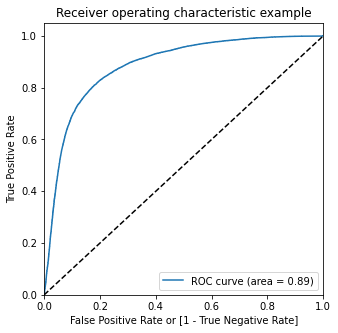

In [112]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

### Finding Optimal Cutoff Point

###### Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [113]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.012348,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0.015760,1,0,1,0,0,0,0,0,0,0,0,0
2,0,0.079598,2,0,1,0,0,0,0,0,0,0,0,0
3,0,0.000165,3,0,1,0,0,0,0,0,0,0,0,0
4,0,0.102669,4,0,1,1,0,0,0,0,0,0,0,0


In [114]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.497016  1.000000  0.000000
0.1   0.1  0.672413  0.978801  0.369660
0.2   0.2  0.735470  0.951136  0.522362
0.3   0.3  0.775090  0.919038  0.632850
0.4   0.4  0.800064  0.882182  0.718921
0.5   0.5  0.813126  0.836181  0.790343
0.6   0.6  0.812621  0.776695  0.848120
0.7   0.7  0.796369  0.691345  0.900146
0.8   0.8  0.737054  0.529281  0.942360
0.9   0.9  0.581007  0.175596  0.981608


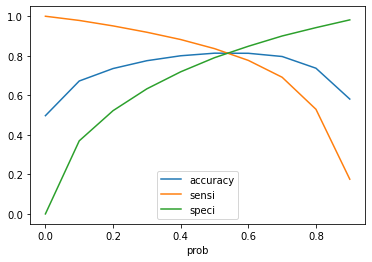

In [115]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.55 is the optimum point to take it as a cutoff probability.

In [116]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.55 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.012348,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.015760,1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.079598,2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.000165,3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.102669,4,0,1,1,0,0,0,0,0,0,0,0,0


In [117]:
# On train data set

print ('Accuracy: ', accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('F1 score: ', f1_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('Recall: ', recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('Precision: ', precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('ROC_AUC_SCORE: ', roc_auc_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('\n clasification report:\n', classification_report(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ('\n confussion matrix:\n',confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted))

Accuracy:  0.8131255164814984
F1 score:  0.8164415683975559
Recall:  0.8361814151117679
Precision:  0.7976122296136393
ROC_AUC_SCORE:  0.8132623030286843

 clasification report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81     21912
           1       0.80      0.84      0.82     21652

    accuracy                           0.81     43564
   macro avg       0.81      0.81      0.81     43564
weighted avg       0.81      0.81      0.81     43564


 confussion matrix:
 [[17318  4594]
 [ 3547 18105]]


## Precision and Recall

### Precision and recall tradeoff

In [118]:
from sklearn.metrics import precision_recall_curve

In [119]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

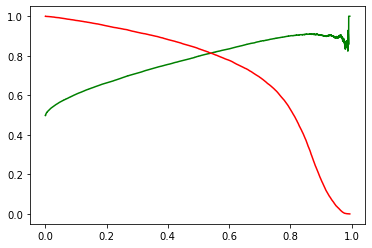

In [120]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

##### Here also threshold is 0.55. We are good to go.

### Making predictions on the test 

In [121]:
X_test = X_test[col]
X_test.head()

,arpu_7,roam_og_mou_8,loc_og_mou_8,loc_ic_mou_7,std_ic_mou_8,spl_ic_mou_8,total_rech_num_8,last_day_rch_amt_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,aon,sep_vbc_3g
69709,0.389633,-0.027837,-0.938003,-0.967154,-0.545952,-0.237328,-0.361298,-1.019865,-0.317397,-0.328033,-0.297299,0.845377,-0.269198
54860,2.453022,3.621939,-0.525748,-0.245547,-0.135485,-0.237328,-0.224310,-1.019865,2.471949,-0.328033,-0.297299,0.417464,-0.269198
68104,-0.015203,0.553242,0.067110,-0.446844,-0.546344,-0.237328,-0.361298,-1.019865,2.471949,0.211149,-0.297299,0.437008,-0.269198
39577,-0.357951,0.286972,1.131727,0.632421,-0.672913,-0.237328,-0.361298,0.593651,-0.317397,-0.328033,-0.297299,2.457253,-0.269198
67566,-0.592869,-0.361716,-0.423852,2.612788,-0.680358,-0.237328,0.460627,-0.895749,-0.317397,-0.328033,-0.297299,0.446265,-0.269198


In [122]:
X_test_sm = sm.add_constant(X_test)

In [123]:
y_test_pred = res.predict(X_test_sm)

In [124]:
y_test_pred[:10]

69709    0.784644
54860    0.850226
68104    0.236502
39577    0.053364
67566    0.458621
52615    0.900066
55093    0.065185
30834    0.356136
67103    0.041796
80343    0.000594
dtype: float64

In [125]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [126]:
# Let's see the head
y_pred_1.head()

,0
69709,0.784644
54860,0.850226
68104,0.236502
39577,0.053364
67566,0.458621


In [127]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [128]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [129]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [130]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [131]:
y_pred_final.head()

,Churn,CustID,0
0,0,69709,0.784644
1,0,54860,0.850226
2,0,68104,0.236502
3,0,39577,0.053364
4,0,67566,0.458621


In [132]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [133]:
# Rearranging the columns
y_pred_final = y_pred_final[['CustID','Churn','Churn_Prob']]

In [134]:
# Let's see the head of y_pred_final
y_pred_final.head()

,CustID,Churn,Churn_Prob
0,69709,0,0.784644
1,54860,0,0.850226
2,68104,0,0.236502
3,39577,0,0.053364
4,67566,0,0.458621


In [135]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.55 else 0)

In [136]:
y_pred_final.head()

,CustID,Churn,Churn_Prob,final_predicted
0,69709,0,0.784644,1
1,54860,0,0.850226,1
2,68104,0,0.236502,0
3,39577,0,0.053364,0
4,67566,0,0.458621,0


In [137]:
print ('Accuracy: ', accuracy_score(y_pred_final.Churn, y_pred_final.final_predicted))
print ('F1 score: ', f1_score(y_pred_final.Churn, y_pred_final.final_predicted))
print ('Recall: ', recall_score(y_pred_final.Churn, y_pred_final.final_predicted))
print ('Precision: ', precision_score(y_pred_final.Churn, y_pred_final.final_predicted))
print ('ROC_AUC_SCORE: ', roc_auc_score(y_pred_final.Churn, y_pred_final.final_predicted))
print ('\n clasification report:\n', classification_report(y_pred_final.Churn, y_pred_final.final_predicted))
print ('\n confussion matrix:\n',confusion_matrix(y_pred_final.Churn, y_pred_final.final_predicted))

Accuracy:  0.8275517011340894
F1 score:  0.45116772823779194
Recall:  0.8204633204633205
Precision:  0.31112737920937045
ROC_AUC_SCORE:  0.8243426496438545

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      5478
           1       0.31      0.82      0.45       518

    accuracy                           0.83      5996
   macro avg       0.65      0.82      0.67      5996
weighted avg       0.92      0.83      0.86      5996


 confussion matrix:
 [[4537  941]
 [  93  425]]


#### Our best model in logistic regression gives quite a good result on test data.
#### The precision is too low but we can count on Recall which is good. 
#### We are preferring recall because it takes False negative Cases on count. Here we need to predict all churning customers.
#### Thats why we could not afford much False Negatives cases.
#### Now will model using decision trees.

# Using Decision Trees

In [138]:
X_train = X_resampled_ada
y_train = y_resampled_ada

In [139]:
X_test = df_test.drop('Churn', axis=1)
y_test = df_test['Churn']

In [140]:
from sklearn.tree import DecisionTreeClassifier

In [141]:
dt_base = DecisionTreeClassifier(random_state=42, max_depth=4)

In [142]:
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [143]:
X_test.shape

(5996, 86)

In [144]:
y_train_pred = dt_base.predict(X_train)
y_test_pred = dt_base.predict(X_test)

In [145]:
print ('Accuracy: ', accuracy_score(y_test, y_test_pred))
print ('F1 score: ', f1_score(y_test, y_test_pred))
print ('Recall: ', recall_score(y_test, y_test_pred))
print ('Precision: ', precision_score(y_test, y_test_pred))
print ('ROC_AUC_SCORE: ', roc_auc_score(y_test, y_test_pred))
print ('\n clasification report:\n', classification_report(y_test,y_test_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_test_pred))

Accuracy:  0.8205470313542361
F1 score:  0.4532520325203252
Recall:  0.861003861003861
Precision:  0.30758620689655175
ROC_AUC_SCORE:  0.8388626460915617

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      5478
           1       0.31      0.86      0.45       518

    accuracy                           0.82      5996
   macro avg       0.65      0.84      0.67      5996
weighted avg       0.93      0.82      0.85      5996


 confussion matrix:
 [[4474 1004]
 [  72  446]]


#### Plot the ROC curve

In [146]:
from sklearn.metrics import plot_roc_curve

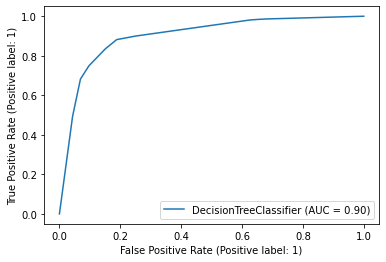

In [147]:
plot_roc_curve(dt_base, X_train, y_train, drop_intermediate=False)
plt.show()

#### Our random decision tree gives good recall but precision and accuracy is low. So lets tune hyperparameters.

## Hyper-parameter tuning for the Decision Tree

In [148]:
from sklearn.model_selection import GridSearchCV

In [149]:
dt = DecisionTreeClassifier(random_state=42)

In [150]:
params = {
    "max_depth": [2,3,5,10,20],
    "min_samples_leaf": [5,10,20,50,100,500]
}

In [151]:
grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [152]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Wall time: 1min 20s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500]},
             scoring='accuracy', verbose=1)

In [153]:
grid_search.best_score_

0.8798549260857589

In [154]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

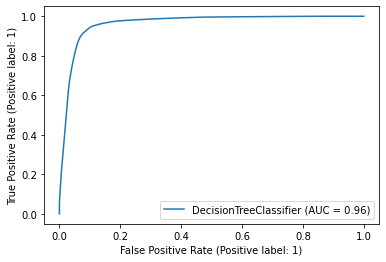

In [155]:
plot_roc_curve(dt_best, X_train, y_train)
plt.show()

In [156]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

In [157]:
print ('Accuracy: ', accuracy_score(y_test, y_test_pred))
print ('F1 score: ', f1_score(y_test, y_test_pred))
print ('Recall: ', recall_score(y_test, y_test_pred))
print ('Precision: ', precision_score(y_test, y_test_pred))
print ('ROC_AUC_SCORE: ', roc_auc_score(y_test, y_test_pred))
print ('\n clasification report:\n', classification_report(y_test,y_test_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_test_pred))

Accuracy:  0.8689126084056037
F1 score:  0.5075187969924811
Recall:  0.7818532818532818
Precision:  0.37569573283859
ROC_AUC_SCORE:  0.8294991126316428

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.92      5478
           1       0.38      0.78      0.51       518

    accuracy                           0.87      5996
   macro avg       0.68      0.83      0.72      5996
weighted avg       0.93      0.87      0.89      5996


 confussion matrix:
 [[4805  673]
 [ 113  405]]


##### Our Decision tree gives improved accuracy and precesion after hyperparameter tuning. Model gives good recall too in test data. But we will try to improve by using feature selection

## Feature Selection using RFECV- Decision Tree estimator

In [158]:
from sklearn.feature_selection import RFECV

In [198]:
rfecv = RFECV(estimator=dt_base, cv=4)

In [199]:
%%time
rfecv.fit(X_train, y_train)

Wall time: 2min 42s


RFECV(cv=4, estimator=DecisionTreeClassifier(max_depth=4, random_state=42))

In [200]:
rfecv.grid_scores_

array([0.74428427, 0.8203333 , 0.83183362, 0.83238454, 0.83614911,
       0.83911027, 0.83897255, 0.84083188, 0.84145166, 0.84191075,
       0.84200257, 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 ,
       0.8428519 , 0.8428519 , 0.8428519 , 0.8428519 , 0.84285

In [201]:
num_features = X_train.shape

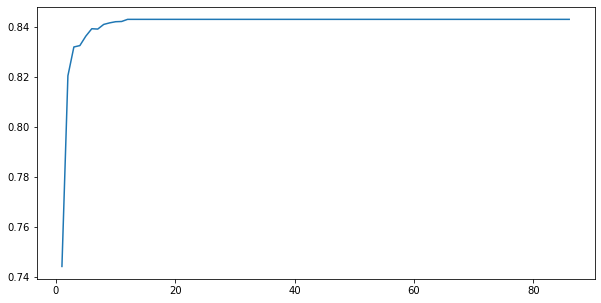

In [202]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, num_features[1]+1), rfecv.grid_scores_)
plt.show()

In [203]:
rfecv.n_features_

12

##### So total features selected is 12

In [204]:
list(zip(X_train.columns, rfecv.support_, rfecv.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', False, 14),
 ('arpu_8', True, 1),
 ('onnet_mou_6', False, 5),
 ('onnet_mou_7', False, 4),
 ('onnet_mou_8', False, 3),
 ('offnet_mou_6', False, 2),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', False, 16),
 ('roam_ic_mou_6', False, 18),
 ('roam_ic_mou_7', False, 20),
 ('roam_ic_mou_8', True, 1),
 ('roam_og_mou_6', False, 24),
 ('roam_og_mou_7', True, 1),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2c_mou_6', False, 29),
 ('loc_og_t2c_mou_7', False, 31),
 ('loc_og_t2c_mou_8', False, 33),
 ('loc_og_mou_6', False, 35),
 ('loc_og_mou_7', False, 37),
 ('loc_og_mou_8', False, 39),
 ('std_og_t2f_mou_6', False, 41),
 ('std_og_t2f_mou_7', False, 43),
 ('std_og_t2f_mou_8', False, 46),
 ('std_og_mou_6', False, 45),
 ('std_og_mou_7', False, 11),
 ('std_og_mou_8', True, 1),
 ('isd_og_mou_6', False, 25),
 ('isd_og_mou_7', False, 47),
 ('isd_og_mou_8', False, 49),
 ('spl_og_mou_6', False, 51),
 ('spl_og_mou_7', False, 53),
 ('spl_og_mou_8', False, 55),
 ('og_others_6', Fa

In [205]:
col = X_train.columns[rfecv.support_]
col

Index(['arpu_6', 'arpu_8', 'offnet_mou_7', 'roam_ic_mou_8', 'roam_og_mou_7',
       'roam_og_mou_8', 'std_og_mou_8', 'loc_ic_mou_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8'],
      dtype='object')

In [206]:
X_train.columns[~rfecv.support_]

Index(['arpu_7', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8',
       'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6',
       'ic_others_7', 'ic_others_8', 'total_rech_num_6', 'total_rech_num_7',
       'total_rech_num_8', 'max_rech_amt_6', 'max

In [207]:
dt_base.fit(X_train[col], y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [208]:
y_train_pred = dt_base.predict(X_train[col])
y_test_pred = dt_base.predict(X_test[col])

In [209]:
print ('Accuracy: ', accuracy_score(y_test, y_test_pred))
print ('F1 score: ', f1_score(y_test, y_test_pred))
print ('Recall: ', recall_score(y_test, y_test_pred))
print ('Precision: ', precision_score(y_test, y_test_pred))
print ('ROC_AUC_SCORE: ', roc_auc_score(y_test, y_test_pred))
print ('\n clasification report:\n', classification_report(y_test,y_test_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_test_pred))

Accuracy:  0.8205470313542361
F1 score:  0.4532520325203252
Recall:  0.861003861003861
Precision:  0.30758620689655175
ROC_AUC_SCORE:  0.8388626460915617

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      5478
           1       0.31      0.86      0.45       518

    accuracy                           0.82      5996
   macro avg       0.65      0.84      0.67      5996
weighted avg       0.93      0.82      0.85      5996


 confussion matrix:
 [[4474 1004]
 [  72  446]]


##### In this model our recall improved but precision lowered. So lets tune  hyperparameters.

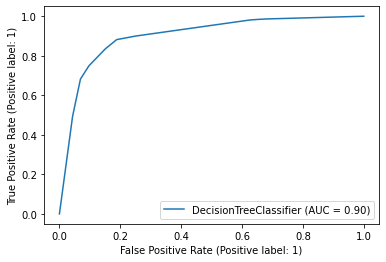

In [210]:
plot_roc_curve(dt_base, X_train[col], y_train, drop_intermediate=False)
plt.show()

## Hyperparameter Tuning after feature selection

In [211]:
params = {
    "max_depth": [2,3,5,10,20],
    "min_samples_leaf": [5,10,20,50,100,500],
    "min_samples_split": [100, 200,500]
}

In [212]:
grid_search = GridSearchCV(estimator=dt_base,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [213]:
%%time
grid_search.fit(X_train[col], y_train)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
Wall time: 41.6 s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(max_depth=4, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500],
                         'min_samples_split': [100, 200, 500]},
             scoring='accuracy', verbose=1)

In [214]:
grid_search.best_score_

0.8668395923239373

In [215]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=20, min_samples_leaf=20, min_samples_split=100,
                       random_state=42)

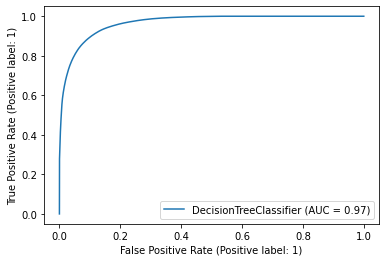

In [216]:
plot_roc_curve(dt_best, X_train[col], y_train)
plt.show()

In [217]:
y_train_pred = dt_best.predict(X_train[col])
y_test_pred = dt_best.predict(X_test[col])

In [218]:
print ('Accuracy: ', accuracy_score(y_test, y_test_pred))
print ('F1 score: ', f1_score(y_test, y_test_pred))
print ('Recall: ', recall_score(y_test, y_test_pred))
print ('Precision: ', precision_score(y_test, y_test_pred))
print ('ROC_AUC_SCORE: ', roc_auc_score(y_test, y_test_pred))
print ('\n clasification report:\n', classification_report(y_test,y_test_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_test_pred))

Accuracy:  0.8629086057371581
F1 score:  0.4907063197026022
Recall:  0.7644787644787645
Precision:  0.3613138686131387
ROC_AUC_SCORE:  0.8183474508775714

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92      5478
           1       0.36      0.76      0.49       518

    accuracy                           0.86      5996
   macro avg       0.67      0.82      0.71      5996
weighted avg       0.92      0.86      0.88      5996


 confussion matrix:
 [[4778  700]
 [ 122  396]]


##### After doing feature selection using rfecv. We took only 12 most important features. After hypertuning our recall, accuracy, precison value slighltly improved but not good enough. Hence we will try for Random Forest

## Using Random Forest

In [184]:
from sklearn.ensemble import RandomForestClassifier

In [185]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

## Hyper-parameter tuning for the Random Forest

In [186]:
from sklearn.model_selection import RandomizedSearchCV

In [187]:
hyper_params = {'max_depth': range(3, 20),
                'max_features': range(3, 17),
                'min_samples_leaf': range(20, 400, 50),
                'n_estimators': range(10, 101, 10)}

In [188]:
model_rcv = RandomizedSearchCV(estimator=rf, 
                              param_distributions=hyper_params,
                              verbose=1,
                              cv=4,
                              return_train_score=True,
                              n_jobs=-1,
                              n_iter=50)

In [189]:
%%time
model_rcv.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Wall time: 7min 29s


RandomizedSearchCV(cv=4,
                   estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(3, 20),
                                        'max_features': range(3, 17),
                                        'min_samples_leaf': range(20, 400, 50),
                                        'n_estimators': range(10, 101, 10)},
                   return_train_score=True, verbose=1)

In [190]:
model_rcv.best_score_

0.9037048939491323

In [191]:
rf_best = model_rcv.best_estimator_
rf_best

RandomForestClassifier(max_depth=19, max_features=16, min_samples_leaf=20,
                       n_jobs=-1, oob_score=True, random_state=42)

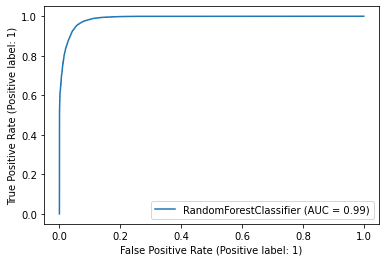

In [192]:
plot_roc_curve(rf_best, X_train, y_train)
plt.show()

In [193]:
y_test_pred = rf_best.predict(X_test)

In [194]:
print ('Accuracy: ', accuracy_score(y_test, y_test_pred))
print ('F1 score: ', f1_score(y_test, y_test_pred))
print ('Recall: ', recall_score(y_test, y_test_pred))
print ('Precision: ', precision_score(y_test, y_test_pred))
print ('ROC_AUC_SCORE: ', roc_auc_score(y_test, y_test_pred))
print ('\n clasification report:\n', classification_report(y_test,y_test_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_test_pred))

Accuracy:  0.9134422948632421
F1 score:  0.6106526631657915
Recall:  0.7857142857142857
Precision:  0.49938650306748467
ROC_AUC_SCORE:  0.8556172742919731

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95      5478
           1       0.50      0.79      0.61       518

    accuracy                           0.91      5996
   macro avg       0.74      0.86      0.78      5996
weighted avg       0.94      0.91      0.92      5996


 confussion matrix:
 [[5070  408]
 [ 111  407]]


#### Here we are getting good enough scores of all metrics like accuracy, precision, recall, roc_auc_score, F1 on our test data.
#### So we are finally recommending this random forest model with estimator as decision tree with best hyperparameters.

In [195]:
rf_best.feature_importances_

array([4.46657286e-03, 6.96903520e-03, 8.56245171e-02, 3.32910405e-03,
       4.24062786e-03, 1.54297917e-02, 3.55650310e-03, 4.93278224e-03,
       2.39033911e-02, 3.88572256e-03, 5.39959929e-03, 8.69170962e-02,
       2.89292928e-03, 9.63960575e-03, 1.38039951e-01, 1.44344561e-03,
       5.43050703e-03, 1.81417981e-03, 5.12689260e-03, 9.37434689e-03,
       7.36594753e-02, 7.74522441e-04, 2.03529521e-03, 7.48405882e-04,
       4.39863430e-03, 8.73712608e-03, 1.07142531e-02, 7.79902240e-04,
       1.56180610e-03, 1.88920299e-03, 5.14158024e-03, 1.27458859e-02,
       6.40117884e-03, 2.70160096e-03, 1.29795527e-05, 2.07724732e-05,
       5.91267206e-03, 8.73235969e-03, 1.12641485e-01, 3.96531330e-03,
       7.69375473e-03, 4.51843498e-03, 2.62125338e-03, 2.38584642e-03,
       2.12191957e-03, 3.03593298e-03, 3.56714074e-03, 2.67272957e-02,
       2.95561282e-03, 3.48509479e-04, 2.82678400e-03, 1.35010499e-03,
       1.77419801e-03, 1.51946841e-03, 1.44843082e-03, 1.49472788e-03,
      

In [196]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [197]:
imp_df.sort_values(by="Imp", ascending=False).head(10)

,Varname,Imp
14,roam_og_mou_8,0.138040
38,loc_ic_mou_8,0.112641
11,roam_ic_mou_8,0.086917
2,arpu_8,0.085625
20,loc_og_mou_8,0.073659
65,last_day_rch_amt_8,0.069584
62,max_rech_amt_8,0.056207
59,total_rech_num_8,0.032445
47,std_ic_mou_8,0.026727
8,offnet_mou_8,0.023903


So most important features for our final model are all from action phase.

Top 10 are listed here

1.  roam_og_mou_8 
2.  loc_ic_mou_8  
3.  roam_ic_mou_8
4.  arpu_8
5.  loc_og_mou_8
6.  last_day_rch_amt_8
7.  max_rech_amt_8
8.  total_rech_num_8
9.  std_ic_mou_8
10. onnet_mou_8 


# Business Recommendations

The company after identifying customers in action phase can give offers for 
increasing local incoming and outgoing minutes of usage
- Customers are more keen towards the local incoming calls over anything so, We can provide more free incoming calls and also we can reduce the outgoing calls charges for btter connectivity. This can provide an advantage over other operators in the market.
- The roaming charges can be made lesser by giving offers. More impoartantly we can provide free incoming calls on roaming. 
- We can provide attractives offers and packages for the customers.
`